In [1]:
import os
import numpy as np
import pandas as pd
import datetime 

pd.set_option('display.max_columns', 100)

In [2]:
os.chdir('..')

In [3]:
pwd

'/Users/A.IVA/Documents/jupyter_notebooks/coursera_and_blogs/rossmann_competition'

### Load data and generate new features

In [4]:
from rossmann.preprocess import load_and_preprocess
from rossmann.feature_generator import promo2_running, dt_since_last_promo, dt_since_first_promo2

In [19]:
data_dir = os.path.join('..', 'data', 'rossmann-store-sales', 'source')
df = load_and_preprocess(data_dir)

df.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id,StoreType,Assortment,CompetitionDistance,competition_since,promos2
0,1,2,2013-01-01,0.0,0.0,0.0,0,a,1,NaN,c,a,1270.0,2008-09-01,None
1,1,3,2013-01-02,5530.0,668.0,1.0,0,0,1,NaN,c,a,1270.0,2008-09-01,None


In [21]:
df['dt_since_last_promo2']  = df[['Date', 'promos2']].apply(lambda x: dt_since_last_promo(x[0], x[1]), 1)
df['dt_since_first_promo2'] = df[['Date', 'promos2']].apply(lambda x: dt_since_first_promo2(x[0], x[1]), 1)

# I will drop the `Date` column and use this column as my the trend generator
df['days_since_start'] = df['Date'].apply(lambda x: (x - datetime.datetime(2013, 1, 1)).days)

df['days_left_yr'] = df['Date'].apply(lambda x: (datetime.datetime(x.year, 12, 31) - x).days)
df['days_since_yr'] = df['Date'].apply(lambda x: (x - datetime.datetime(x.year, 1, 1)).days)

df['weeks_left_yr'] = df['days_left_yr'] // 7
df['weeks_since_yr'] = df['days_since_yr'] // 7

# two options for 'competition_since'
# competition already here (binary) or days since competition is here (continuous variable)
# df['last_competitor_here'] = (df['competition_since'] <= df['Date']).astype(int)
df['competition_since_days'] = df['Date'] - df['competition_since']
df['competition_since_days'] = df['competition_since_days'].apply(lambda x: x.days)

df['CompetitionDistance'] = df['CompetitionDistance'].fillna(100000).astype(int)

In [22]:
mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
df['StateHoliday'] = df['StateHoliday'].replace(mappings).astype(int)
df['Assortment'] = df['Assortment'].replace(mappings).astype(int)
df['StoreType'] = df['StoreType'].replace(mappings).astype(int)

# df = pd.concat([df.drop(['StateHoliday'], 1),
#                 pd.get_dummies(df['StateHoliday'], prefix='state_hol_')], axis=1, sort=False)

# df = pd.concat([df.drop(['Assortment'], 1),
#                 pd.get_dummies(df['Assortment'], prefix='assortment_')], axis=1, sort=False)

# df = pd.concat([df.drop(['StoreType'], 1),
#                 pd.get_dummies(df['StoreType'], prefix='store_type_')], axis=1, sort=False)


In [38]:
df.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id,StoreType,Assortment,CompetitionDistance,competition_since,promos2,dt_since_last_promo2,dt_since_first_promo2,days_since_start,days_left_yr,days_since_yr,weeks_left_yr,weeks_since_yr,competition_since_days
0,1,2,2013-01-01,0.0,0.0,0.0,0,1,1,NaN,3,1,1270,2008-09-01,None,-360,-2556,0,364,0,52,0,1583
1,1,3,2013-01-02,5530.0,668.0,1.0,0,0,1,NaN,3,1,1270,2008-09-01,None,-360,-2555,1,363,1,51,0,1584


In [39]:
feature_pairs=[
    ('Store', 'int'),
            
    ('DayOfWeek', 'int'),
    ('days_since_start', 'q'),
    ('days_since_yr', 'q'),
    ('weeks_since_yr', 'q'),

    ('days_left_yr', 'q'),
    ('weeks_left_yr', 'q'),

    ('Promo', 'i'),
    ('dt_since_last_promo2', 'q'),
    ('dt_since_first_promo2', 'q'),

    #     ('state_hol__0', 'i'), ('state_hol__a', 'i'), ('state_hol__b', 'i'), ('state_hol__c', 'i'), # 'StateHoliday',
    ('StateHoliday', 'int'),
    ('SchoolHoliday', 'i'),

    #     ('store_type__a', 'i'), ('store_type__b', 'i'), ('store_type__c', 'i'), ('store_type__d', 'i'), # 'StoreType',
    #     ('assortment__a', 'i'), ('assortment__b', 'i'), ('assortment__c', 'i'), # 'Assortment',
    ('StoreType', 'int'),
    ('Assortment', 'int'),

    ('CompetitionDistance', 'q'),
    ('competition_since_days', 'q')
]

features = list(map(lambda x: x[0], feature_pairs))
feature_types = list(map(lambda x: x[1], feature_pairs))

In [44]:
df[features].dtypes

Store                     int64
DayOfWeek                 int64
days_since_start          int64
days_since_yr             int64
weeks_since_yr            int64
days_left_yr              int64
weeks_left_yr             int64
Promo                     int64
dt_since_last_promo2      int64
dt_since_first_promo2     int64
StateHoliday              int64
SchoolHoliday             int64
StoreType                 int64
Assortment                int64
CompetitionDistance       int64
competition_since_days    int64
dtype: object

In [11]:
#
# Prediction
#

# n_stores = 4
# start = time.time()

# We can immediately predict the 'Sales' if the store is closed.
# df['Sales'] = df[['Open', 'Sales']].apply(lambda x: 0 if x[0] == 0 else x[1], 1)

# Instead of predicting Sales we could predict log(Sales + 1)
# df['Sales_log1p'] = np.log1p(df['Sales'])

# df['Sales_log'] = np.log(df['Sales'])


# get the indices of all stores
# all_stores = list(df['Store'].drop_duplicates().values)
# if n_stores is not None:
#     all_stores = all_stores[:n_stores]

In [45]:
import xgboost as xgb
from time import time

In [51]:
params = {
    "objective": "reg:squarederror", # reg:squarederror for regression problems, reg:logistic for classification problems with only decision, binary:logistic classification problems with probability 
    "booster" : "gbtree", # All you have to do is set the booster parameter to either gbtree (default), gblinear or dart.
    "eta": 0.05,
    "max_depth": 10,
    # "min_child_weight"
    # "max_delta_step" # Maximum delta step we allow each leaf output to be
    # "scale_pos_weight" # Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances)
    # "updater" [default= grow_colmaker,prune]
    # "max_bin", [default=256] # Maximum number of discrete bins to bucket continuous features. Only used if tree_method is set to hist.
    # "max_leaves" [default=0] # Maximum number of nodes to be added. Only relevant when grow_policy=lossguide is set
    "subsample": 0.8, # Subsample ratio of the training instances
    "colsample_bytree": 0.7,
    "verbosity": 1,
    "nthread": 2,
    "seed": 10
    }

# gamma: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
# alpha: L1 regularization on leaf weights. A large value leads to more regularization.
# lambda: L2 regularization on leaf weights and is smoother than L1 regularization.

# XGBoost's relatively less popular linear base learners and one other tree learner known as dart. 
# All you have to do is set the booster parameter to either gbtree (default), gblinear or dart.

# n_estimators = number of trees to build

# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 5, alpha = 10, n_estimators = 10)



In [52]:
# train and validation splitting
# Training for the time period [2013/01/01, 2015/03/31]
# Validation for the time period [2015/04/01, 2015/07/31]

t1, t2 = datetime.datetime(2015, 4, 1), datetime.datetime(2015, 7, 31)

df_tr = df[(df['Date'] < t1) & (df['Open'] == 1)].copy(deep=True)
df_va = df[(df['Date'].between(t1, t2, inclusive=True)) & (df['Open'] == 1)].copy(deep=True)
df_te = df[df['Date'] > t2].copy(deep=True)


In [53]:
df_tr[features].head(2)

,Store,DayOfWeek,days_since_start,days_since_yr,weeks_since_yr,days_left_yr,weeks_left_yr,Promo,dt_since_last_promo2,dt_since_first_promo2,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,competition_since_days
1,1,3,1,1,0,363,51,0,-360,-2555,0,1,3,1,1270,1584
2,1,4,2,2,0,362,51,0,-360,-2554,0,1,3,1,1270,1585


In [54]:
from rossmann.utils import rmspe_xg

In [56]:
num_boost_round = 2
label_col = 'Sales'
train_log = dict()

dtr = xgb.DMatrix(data=df_tr[features].to_numpy(), 
                  label=df_tr[label_col].to_numpy(), 
                  feature_names=features,
                  feature_types=feature_types)

dva = xgb.DMatrix(data=df_va[features].to_numpy(), 
                  label=df_va[label_col].to_numpy(), 
                  feature_names=features,
                  feature_types=feature_types)

watchlist = [(dtr, 'train'), (dva, 'eval')]


print("Train a XGBoost model")
start = time()
gbm = xgb.train(params, dtr, num_boost_round, 
                evals=watchlist, 
                early_stopping_rounds=10, 
                feval=rmspe_xg,
                evals_result=train_log,
                verbose_eval=True)
end = time()
print('Training time is {:2f} s.'.format(end-start))

Train a XGBoost model
[0]	train-rmse:7241.36	eval-rmse:7533.8	train-rmspe:0.943468	eval-rmspe:0.944605
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 10 rounds.
[1]	train-rmse:6931.07	eval-rmse:7154.63	train-rmspe:0.889524	eval-rmspe:0.882703
Training time is 3.602467 s.


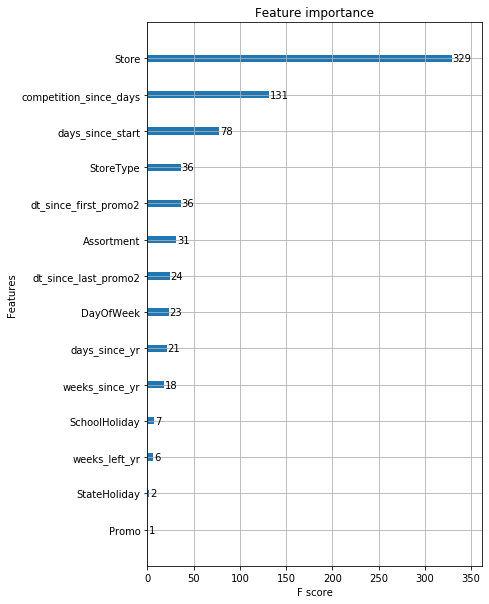

In [66]:
import matplotlib.pyplot as plt

fig = xgb.plot_importance(gbm)
plt.rcParams['figure.figsize'] = [6, 10]
fig.get_figure().savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)

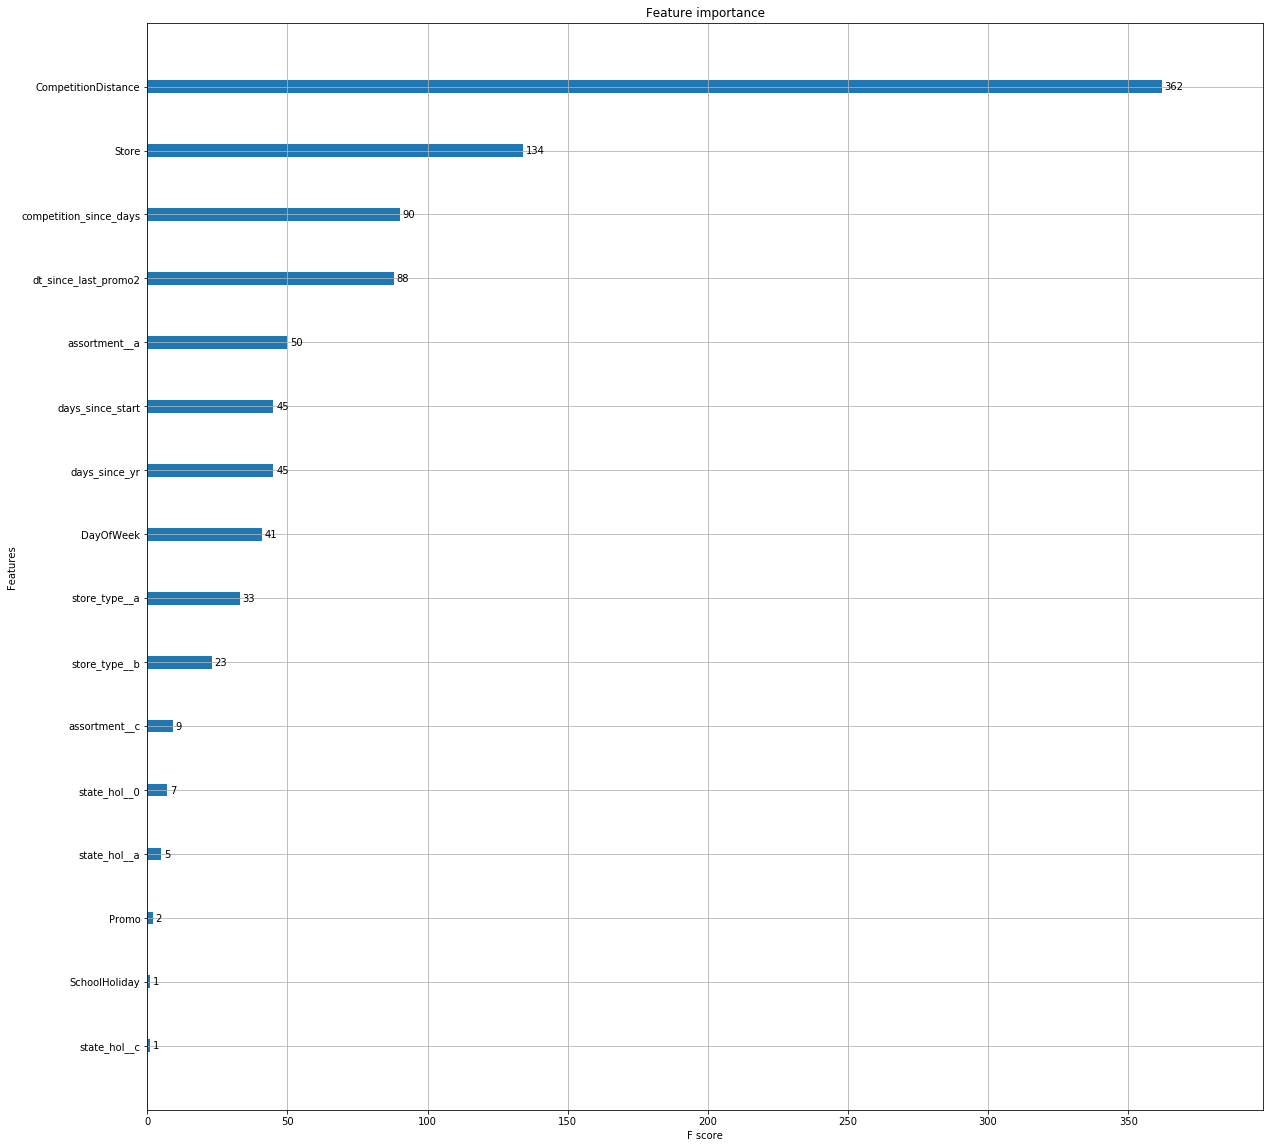

In [81]:
import matplotlib.pyplot as plt

xgb.plot_importance(gbm)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

In [49]:
# Only format is corect
# def create_feature_map(features):
#     outfile = open('xgb.fmap', 'w')
#     for i, feat in enumerate(features):
#         outfile.write('{0}\t{1}\tq\n'.format(i, feat))
#     outfile.close()


In [51]:
# create_feature_map(features)

In [82]:
gbm.get_fscore()

{'Promo': 2,
 'store_type__b': 23,
 'days_since_yr': 45,
 'dt_since_last_promo2': 88,
 'assortment__a': 50,
 'CompetitionDistance': 362,
 'competition_since_days': 90,
 'store_type__a': 33,
 'days_since_start': 45,
 'state_hol__0': 7,
 'state_hol__c': 1,
 'assortment__c': 9,
 'Store': 134,
 'DayOfWeek': 41,
 'state_hol__a': 5,
 'SchoolHoliday': 1}

In [70]:
# geenrate predictoins

# We can immediately predict the 'Sales' if the store is closed.
df_te.loc[df_te['Open'] == 0, 'Sales'] = 0
df_te.loc[df_te['Open'] == 1, 'Sales'] = gbm.predict(xgb.DMatrix(data=df_te[df_te['Open'] == 1][features].to_numpy(), 
                                                                 feature_names=features))

predictions = df_te[['Id', 'Sales']].copy(deep=True)
predictions['Id'] = predictions['Id'].astype(int)
predictions = predictions.set_index(['Id'], drop=True)
predictions[['Sales']].sort_index().to_csv('temp.csv')

In [83]:
# human readable version
gbm.dump_model(os.path.join('dump.raw.txt'))


In [48]:
# human readable version
bst.dump_model(os.path.join(output_dir, 'dump.raw.txt'))

# save model
gbm.save_model('gbm.model')

# load model 
gbm_loaded = xgb.Booster(model_file='gbm.model')



import json

with open('train_log.json', 'w') as f:
    json.dump(train_log, f)